# **LG01 - Prediksi Penilaian Operator Menggunakan Perbandingan Model - RISTEK FASILKOM UI DATATHON 2025**

---



Setelah Model 1 berhasil mengidentifikasi komponen yang berpotensi cacat, Task 2 bertujuan untuk menjawab pertanyaan yang lebih sulit: "Dari semua komponen yang dianggap cacat oleh mesin, mana yang akan benar-benar dinilai 'Bad' oleh operator manusia?"

Tugas ini sangat penting untuk meningkatkan efisiensi operasional. Model yang akurat dapat secara signifikan mengurangi jumlah "alarm palsu" (false positive), sehingga operator hanya perlu memverifikasi kasus-kasus yang paling krusial.

## **Import Library & Dataset**

---



In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 20.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

import catboost as cb
import lightgbm as lgb
import xgboost as xgb
import optuna
import joblib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

**Upload kaggle.json**

Open Kaggle -> Settings -> Account -> API -> Create New Token -> Upload the file here

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#!/bin/bash
!kaggle datasets download rizkyfadhilahjhhhh/dataset-lg01

Dataset URL: https://www.kaggle.com/datasets/rizkyfadhilahjhhhh/dataset-lg01
License(s): unknown
 76% 245M/323M [00:00<00:00, 742MB/s] 
100% 323M/323M [00:00<00:00, 694MB/s]


In [ ]:
!unzip dataset-lg01.zip

Archive:  dataset-lg01.zip
  inflating: PCB Dataset/AOI_testing.csv  
  inflating: PCB Dataset/AOI_training.csv  
  inflating: PCB Dataset/SPI_testing_0.csv  
  inflating: PCB Dataset/SPI_testing_1.csv  
  inflating: PCB Dataset/SPI_training_0.csv  
  inflating: PCB Dataset/SPI_training_1.csv  
  inflating: PCB Dataset/SPI_training_2.csv  
  inflating: PCB Dataset/SPI_training_3.csv  


In [ ]:
aoi_train = pd.read_csv('/content/PCB Dataset/AOI_training.csv')
spi_0 = pd.read_csv('/content/PCB Dataset/SPI_training_0.csv')
spi_1 = pd.read_csv('/content/PCB Dataset/SPI_training_1.csv')
spi_2 = pd.read_csv('/content/PCB Dataset/SPI_training_2.csv')
spi_3 = pd.read_csv('/content/PCB Dataset/SPI_training_3.csv')
merged_spi = pd.concat([spi_0, spi_1, spi_2, spi_3])

/tmp/ipython-input-6-2161004873.py:4: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  spi_2 = pd.read_csv('/content/PCB Dataset/SPI_training_2.csv')


## **Data Preprocessing and Feature Engineering**

---



Pembersihan Data: Menyamakan tipe data untuk memastikan proses penggabungan berjalan lancar.

Penggabungan Data: Melakukan left join dari data AOI ke data SPI untuk mendapatkan data akhir dari setiap komponen yang diinspeksi.

Target Engineering: Membuat variabel target biner (target_1_is_defect dan target_2_operator_bad) sesuai dengan struktur masalah hirarkis.

Feature Engineering: Membuat fitur-fitur baru yang lebih informatif berdasarkan wawasan dari EDA, seperti offset_magnitude untuk merepresentasikan total pergeseran, volume_area_ratio, dan fitur berbasis waktu.

In [ ]:
def preprocess_task2(spi_df, aoi_df):
    for df in [spi_df, aoi_df]:
        for col in ['FigureID', 'PinNumber']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    spi_df['Datetime'] = pd.to_datetime(spi_df['Date'] + ' ' + spi_df['Time'], errors='coerce')
    df = pd.merge(aoi_df, spi_df, on=['PanelID', 'FigureID', 'ComponentID', 'PinNumber'], how='left')
    df = df[df['Datetime'].notna()].copy()
    df['target_is_defect'] = (df['AOILabel'] != 'Soldered').astype(int)
    df = df[df['target_is_defect'] == 1].copy()

    df['OperatorLabel'] = df['OperatorLabel'].fillna('Unknown')
    le = LabelEncoder()
    df['target_operator_label'] = le.fit_transform(df['OperatorLabel'])
    df['MachineID'] = df['MachineID'].astype('category').cat.codes
    df['ComponentID_cat'] = df['ComponentID'].astype('category').cat.codes
    df['Shape(um)'] = pd.to_numeric(df['Shape(um)'], errors='coerce')
    df['spi_hour'] = df['Datetime'].dt.hour
    df['spi_dayofweek'] = df['Datetime'].dt.dayofweek
    df['spi_is_weekend'] = (df['spi_dayofweek'] >= 5).astype(int)
    df['offset_magnitude'] = np.sqrt(df['OffsetX(%)']**2 + df['OffsetY(%)']**2)
    df['volume_area_ratio'] = df['Volume(%)'] / (df['Area(%)'] + 1e-6)
    drop_cols = ['PanelID', 'FigureID', 'PinNumber', 'ComponentID', 'Date', 'Time', 'Datetime',
                 'AOILabel', 'OperatorLabel', 'RepairLabel', 'MachinePrediction', 'Result',
                 'Is_Defect', 'Is_Defect_Label', 'Volume(um3)', 'Area(um2)', 'target_is_defect']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)
    return df, le

## **Optimasi Hyperparameter & Pelatihan**

---



Setelah mempersiapkan data, langkah selanjutnya adalah melatih model. Namun, daripada menggunakan hyperparameter default yang mungkin tidak optimal, kami menerapkan proses optimasi hyperparameter otomatis menggunakan Optuna.

In [ ]:
def train_best_model(model_name, X_train, y_train, X_val, y_val, n_classes, cat_features=None):
    def objective(trial):
        if model_name == 'catboost':
            params = {
                'iterations': 1000,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'depth': trial.suggest_int('depth', 4, 10),
                'loss_function': 'MultiClass',
                'eval_metric': 'TotalF1',
                'random_seed': 42,
                'verbose': 0,

            }
            model = cb.CatBoostClassifier(**params)
        elif model_name == 'lightgbm':
            params = {
                'objective': 'multiclass',
                'num_class': n_classes,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'max_depth': trial.suggest_int('max_depth', 4, 10),
                'metric': 'multi_logloss',
                'random_state': 42,

            }
            model = lgb.LGBMClassifier(**params)
        elif model_name == 'xgboost':
            params = {
                'objective': 'multi:softprob',
                'num_class': n_classes,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'max_depth': trial.suggest_int('max_depth', 4, 10),
                'eval_metric': 'mlogloss',
                'seed': 42,
                'use_label_encoder': False,

            }
            model = xgb.XGBClassifier(**params)
        else:
            raise ValueError("Unknown model")
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        preds = model.predict(X_val)

        preds = model.predict(X_val)

        if preds.ndim > 1:
          preds = np.argmax(preds, axis=1)

        return f1_score(y_val, preds, average='macro')
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    best_params = study.best_params
    if model_name == 'catboost':
        best_params.update({'iterations': 1000, 'loss_function': 'MultiClass', 'random_seed': 42, 'verbose': 0, 'early_stopping_rounds': 30, 'auto_class_weights': 'Balanced' })
        model = cb.CatBoostClassifier(**best_params, cat_features=cat_features)
    elif model_name == 'lightgbm':
        best_params.update({'objective': 'multiclass', 'num_class': n_classes, 'random_state': 42, 'early_stopping_rounds': 30})
        model = lgb.LGBMClassifier(**best_params)
    else:
        best_params.update({'objective': 'multi:softprob', 'num_class': n_classes, 'eval_metric': 'mlogloss', 'seed': 42, 'use_label_encoder': False, 'early_stopping_rounds': 30})
        model = xgb.XGBClassifier(**best_params)

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    return model

## **Pendekatan Alternatif: LSTM**

In [ ]:
class PCBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc = nn.Linear(64, output_size)
    def forward(self, x):
        x = x.unsqueeze(1)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

In [ ]:
def train_lstm(X_train, y_train, X_val, y_val, n_classes):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    train_loader = DataLoader(PCBDataset(pd.DataFrame(X_train_scaled), y_train), batch_size=64, shuffle=True)
    val_loader = DataLoader(PCBDataset(pd.DataFrame(X_val_scaled), y_val), batch_size=64)
    model = LSTMClassifier(input_size=X_train.shape[1], output_size=n_classes)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_val_loss = float('inf')
    patience, counter = 3, 0

    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                loss = loss_fn(model(xb), yb)
                val_losses.append(loss.item())

        avg_val = np.mean(val_losses)
        print(f"Epoch {epoch+1}, Val Loss: {avg_val:.4f}")

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), "best_lstm.pt")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break
    model.load_state_dict(torch.load("best_lstm.pt"))
    return model, scaler, X_val_scaled

## **Fungsi Evaluasi Model**

---



In [ ]:
def evaluate_model(y_true, y_pred, labels, name):
    if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)

    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Oranges')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## **Persiapan Data untuk Pemodelan**

---



In [ ]:
df, le = preprocess_task2(merged_spi, aoi_train)
X = df.drop(columns=['target_operator_label'])
y = df['target_operator_label']
labels = le.classes_
n_classes = len(labels)
categorical_features_indices = [X.columns.get_loc(c) for c in ['MachineID', 'ComponentID_cat'] if c in X]

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## **Pelatihan dan Optimasi Model**

---



In [ ]:
cat_model = train_best_model('catboost', X_train, y_train, X_val, y_val, n_classes, cat_features=categorical_features_indices)
lgb_model = train_best_model('lightgbm', X_train, y_train, X_val, y_val, n_classes)
xgb_model = train_best_model('xgboost', X_train, y_train, X_val, y_val, n_classes)
lstm_model, scaler_lstm, X_val_scaled = train_lstm(X_train, y_train, X_val, y_val, n_classes)

[I 2025-07-09 07:44:47,939] A new study created in memory with name: no-name-3d6195c9-0936-47c8-8b76-d1bb54cd7266
[I 2025-07-09 07:45:01,462] Trial 0 finished with value: 0.041970802919708027 and parameters: {'learning_rate': 0.06472516813761654, 'depth': 7}. Best is trial 0 with value: 0.041970802919708027.
[I 2025-07-09 07:45:42,614] Trial 1 finished with value: 0.041970802919708027 and parameters: {'learning_rate': 0.07100524393747154, 'depth': 9}. Best is trial 0 with value: 0.041970802919708027.
[I 2025-07-09 07:45:48,268] Trial 2 finished with value: 0.041970802919708027 and parameters: {'learning_rate': 0.09758279472251168, 'depth': 5}. Best is trial 0 with value: 0.041970802919708027.
[I 2025-07-09 07:45:54,629] Trial 3 finished with value: 0.041970802919708027 and parameters: {'learning_rate': 0.07266262715380557, 'depth': 4}. Best is trial 0 with value: 0.041970802919708027.
[I 2025-07-09 07:45:59,041] Trial 4 finished with value: 0.041970802919708027 and parameters: {'learni

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-07-09 07:53:15,152] Trial 0 finished with value: 0.8403190950081374 and parameters: {'learning_rate': 0.02869318804961829, 'max_depth': 6}. Best is trial 0 with value: 0.8403190950081374.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997


[I 2025-07-09 07:53:15,706] Trial 1 finished with value: 0.8459219337797818 and parameters: {'learning_rate': 0.027857970434180826, 'max_depth': 9}. Best is trial 1 with value: 0.8459219337797818.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997


[I 2025-07-09 07:53:16,237] Trial 2 finished with value: 0.8530547190955459 and parameters: {'learning_rate': 0.030226674623321757, 'max_depth': 10}. Best is trial 2 with value: 0.8530547190955459.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-07-09 07:53:16,593] Trial 3 finished with value: 0.8463208062655576 and parameters: {'learning_rate': 0.05641261720544845, 'max_depth': 4}. Best is trial 2 with value: 0.8530547190955459.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 07:53:17,116] Trial 4 finished with value: 0.8585998240353365 and parameters: {'learning_rate': 0.03611895958252964, 'max_depth': 10}. Best is trial 4 with value: 0.8585998240353365.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997


[I 2025-07-09 07:53:17,631] Trial 5 finished with value: 0.8731159158351337 and parameters: {'learning_rate': 0.04604431018254471, 'max_depth': 7}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-07-09 07:53:18,089] Trial 6 finished with value: 0.8136626762046951 and parameters: {'learning_rate': 0.012084959586820678, 'max_depth': 6}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997


[I 2025-07-09 07:53:18,668] Trial 7 finished with value: 0.8349371622852286 and parameters: {'learning_rate': 0.015521777274120416, 'max_depth': 8}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997


[I 2025-07-09 07:53:19,479] Trial 8 finished with value: 0.8675992165236177 and parameters: {'learning_rate': 0.050237032815536216, 'max_depth': 10}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-07-09 07:53:20,178] Trial 9 finished with value: 0.8655294298447825 and parameters: {'learning_rate': 0.05719034341638579, 'max_depth': 6}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 07:53:20,724] Trial 10 finished with value: 0.8479312209272387 and parameters: {'learning_rate': 0.0898197464178749, 'max_depth': 4}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-07-09 07:53:21,550] Trial 11 finished with value: 0.8710180245449954 and parameters: {'learning_rate': 0.07222449616027496, 'max_depth': 8}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-07-09 07:53:22,065] Trial 12 finished with value: 0.8689411275223633 and parameters: {'learning_rate': 0.08354592990796332, 'max_depth': 8}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2025-07-09 07:53:22,601] Trial 13 finished with value: 0.8710180245449954 and parameters: {'learning_rate': 0.0753132287868768, 'max_depth': 7}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997


[I 2025-07-09 07:53:23,133] Trial 14 finished with value: 0.8655294298447825 and parameters: {'learning_rate': 0.06777816998885904, 'max_depth': 8}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 07:53:23,641] Trial 15 finished with value: 0.8668848943720642 and parameters: {'learning_rate': 0.09994749490411317, 'max_depth': 7}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2025-07-09 07:53:24,067] Trial 16 finished with value: 0.8520126282557221 and parameters: {'learning_rate': 0.04546703120455575, 'max_depth': 5}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 07:53:24,584] Trial 17 finished with value: 0.8731159158351337 and parameters: {'learning_rate': 0.06545630049445225, 'max_depth': 7}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 07:53:25,015] Trial 18 finished with value: 0.8499613377463303 and parameters: {'learning_rate': 0.06132737945137935, 'max_depth': 5}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-09 07:53:25,543] Trial 19 finished with value: 0.8696900339149181 and parameters: {'learning_rate': 0.04256865476446564, 'max_depth': 7}. Best is trial 5 with value: 0.8731159158351337.


[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2722
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 19
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] Start training from score -3.123566
[LightGBM] [Info] Start training from score -0.044997
Training until validation scores don't improve for 30 rounds


[I 2025-07-09 07:53:26,010] A new study created in memory with name: no-name-55cc0961-7770-48b2-8be0-79ffa9893f30


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[97]	valid_0's multi_logloss: 0.0729809
[0]	validation_0-mlogloss:0.61172
[1]	validation_0-mlogloss:0.54393
[2]	validation_0-mlogloss:0.48709
[3]	validation_0-mlogloss:0.43864
[4]	validation_0-mlogloss:0.39654
[5]	validation_0-mlogloss:0.36014
[6]	validation_0-mlogloss:0.32862
[7]	validation_0-mlogloss:0.30084
[8]	validation_0-mlogloss:0.27589
[9]	validation_0-mlogloss:0.25416
[10]	validation_0-mlogloss:0.23475
[11]	validation_0-mlogloss:0.21767
[12]	validation_0-mlogloss:0.20246
[13]	validation_0-mlogloss:0.18885


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-mlogloss:0.17668
[15]	validation_0-mlogloss:0.16580
[16]	validation_0-mlogloss:0.15597
[17]	validation_0-mlogloss:0.14715
[18]	validation_0-mlogloss:0.13914
[19]	validation_0-mlogloss:0.13210
[20]	validation_0-mlogloss:0.12584
[21]	validation_0-mlogloss:0.11997
[22]	validation_0-mlogloss:0.11450
[23]	validation_0-mlogloss:0.10969
[24]	validation_0-mlogloss:0.10532
[25]	validation_0-mlogloss:0.10148
[26]	validation_0-mlogloss:0.09821
[27]	validation_0-mlogloss:0.09511
[28]	validation_0-mlogloss:0.09224
[29]	validation_0-mlogloss:0.08982
[30]	validation_0-mlogloss:0.08762
[31]	validation_0-mlogloss:0.08577
[32]	validation_0-mlogloss:0.08430
[33]	validation_0-mlogloss:0.08300
[34]	validation_0-mlogloss:0.08144
[35]	validation_0-mlogloss:0.08013
[36]	validation_0-mlogloss:0.07892
[37]	validation_0-mlogloss:0.07795
[38]	validation_0-mlogloss:0.07672
[39]	validation_0-mlogloss:0.07588
[40]	validation_0-mlogloss:0.07521
[41]	validation_0-mlogloss:0.07445
[42]	validation_0-ml

[I 2025-07-09 07:53:27,765] Trial 0 finished with value: 0.8786326151466497 and parameters: {'learning_rate': 0.09205181228437267, 'max_depth': 9}. Best is trial 0 with value: 0.8786326151466497.


[0]	validation_0-mlogloss:0.62309
[1]	validation_0-mlogloss:0.56347
[2]	validation_0-mlogloss:0.51201
[3]	validation_0-mlogloss:0.46708
[4]	validation_0-mlogloss:0.42801
[5]	validation_0-mlogloss:0.39366
[6]	validation_0-mlogloss:0.36320
[7]	validation_0-mlogloss:0.33647
[8]	validation_0-mlogloss:0.31240
[9]	validation_0-mlogloss:0.29096
[10]	validation_0-mlogloss:0.27150
[11]	validation_0-mlogloss:0.25405
[12]	validation_0-mlogloss:0.23834
[13]	validation_0-mlogloss:0.22401
[14]	validation_0-mlogloss:0.21118
[15]	validation_0-mlogloss:0.19951
[16]	validation_0-mlogloss:0.18927
[17]	validation_0-mlogloss:0.17997
[18]	validation_0-mlogloss:0.17157
[19]	validation_0-mlogloss:0.16385
[20]	validation_0-mlogloss:0.15651
[21]	validation_0-mlogloss:0.14990
[22]	validation_0-mlogloss:0.14370


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-mlogloss:0.13816
[24]	validation_0-mlogloss:0.13339
[25]	validation_0-mlogloss:0.12878
[26]	validation_0-mlogloss:0.12450
[27]	validation_0-mlogloss:0.12087
[28]	validation_0-mlogloss:0.11711
[29]	validation_0-mlogloss:0.11389
[30]	validation_0-mlogloss:0.11122
[31]	validation_0-mlogloss:0.10848
[32]	validation_0-mlogloss:0.10600
[33]	validation_0-mlogloss:0.10410
[34]	validation_0-mlogloss:0.10177
[35]	validation_0-mlogloss:0.10007
[36]	validation_0-mlogloss:0.09845
[37]	validation_0-mlogloss:0.09669
[38]	validation_0-mlogloss:0.09550
[39]	validation_0-mlogloss:0.09357
[40]	validation_0-mlogloss:0.09252
[41]	validation_0-mlogloss:0.09157
[42]	validation_0-mlogloss:0.09057
[43]	validation_0-mlogloss:0.08962
[44]	validation_0-mlogloss:0.08842
[45]	validation_0-mlogloss:0.08769
[46]	validation_0-mlogloss:0.08705
[47]	validation_0-mlogloss:0.08616
[48]	validation_0-mlogloss:0.08568
[49]	validation_0-mlogloss:0.08516
[50]	validation_0-mlogloss:0.08425
[51]	validation_0-ml

[I 2025-07-09 07:53:28,558] Trial 1 finished with value: 0.8540854440761687 and parameters: {'learning_rate': 0.07988729929619436, 'max_depth': 4}. Best is trial 0 with value: 0.8786326151466497.


[0]	validation_0-mlogloss:0.68262
[1]	validation_0-mlogloss:0.67232
[2]	validation_0-mlogloss:0.66226
[3]	validation_0-mlogloss:0.65242
[4]	validation_0-mlogloss:0.64284
[5]	validation_0-mlogloss:0.63348
[6]	validation_0-mlogloss:0.62427
[7]	validation_0-mlogloss:0.61530
[8]	validation_0-mlogloss:0.60648
[9]	validation_0-mlogloss:0.59785
[10]	validation_0-mlogloss:0.58942
[11]	validation_0-mlogloss:0.58119
[12]	validation_0-mlogloss:0.57306
[13]	validation_0-mlogloss:0.56514
[14]	validation_0-mlogloss:0.55739
[15]	validation_0-mlogloss:0.54978
[16]	validation_0-mlogloss:0.54232


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-mlogloss:0.53502
[18]	validation_0-mlogloss:0.52786
[19]	validation_0-mlogloss:0.52080
[20]	validation_0-mlogloss:0.51390
[21]	validation_0-mlogloss:0.50710
[22]	validation_0-mlogloss:0.50048
[23]	validation_0-mlogloss:0.49393
[24]	validation_0-mlogloss:0.48756
[25]	validation_0-mlogloss:0.48125
[26]	validation_0-mlogloss:0.47510
[27]	validation_0-mlogloss:0.46901
[28]	validation_0-mlogloss:0.46302
[29]	validation_0-mlogloss:0.45715
[30]	validation_0-mlogloss:0.45139
[31]	validation_0-mlogloss:0.44573
[32]	validation_0-mlogloss:0.44015
[33]	validation_0-mlogloss:0.43468
[34]	validation_0-mlogloss:0.42931
[35]	validation_0-mlogloss:0.42403
[36]	validation_0-mlogloss:0.41884
[37]	validation_0-mlogloss:0.41374
[38]	validation_0-mlogloss:0.40873
[39]	validation_0-mlogloss:0.40380
[40]	validation_0-mlogloss:0.39899
[41]	validation_0-mlogloss:0.39427
[42]	validation_0-mlogloss:0.38960
[43]	validation_0-mlogloss:0.38502
[44]	validation_0-mlogloss:0.38053
[45]	validation_0-ml

[I 2025-07-09 07:53:29,605] Trial 2 finished with value: 0.8535633979299335 and parameters: {'learning_rate': 0.011431712834752208, 'max_depth': 6}. Best is trial 0 with value: 0.8786326151466497.


[0]	validation_0-mlogloss:0.61569
[1]	validation_0-mlogloss:0.55106
[2]	validation_0-mlogloss:0.49621
[3]	validation_0-mlogloss:0.44869
[4]	validation_0-mlogloss:0.40733
[5]	validation_0-mlogloss:0.37126
[6]	validation_0-mlogloss:0.33992
[7]	validation_0-mlogloss:0.31207
[8]	validation_0-mlogloss:0.28768
[9]	validation_0-mlogloss:0.26566
[10]	validation_0-mlogloss:0.24602
[11]	validation_0-mlogloss:0.22853
[12]	validation_0-mlogloss:0.21313
[13]	validation_0-mlogloss:0.19932
[14]	validation_0-mlogloss:0.18690
[15]	validation_0-mlogloss:0.17565


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-mlogloss:0.16569
[17]	validation_0-mlogloss:0.15654
[18]	validation_0-mlogloss:0.14825
[19]	validation_0-mlogloss:0.14082
[20]	validation_0-mlogloss:0.13406
[21]	validation_0-mlogloss:0.12792
[22]	validation_0-mlogloss:0.12229
[23]	validation_0-mlogloss:0.11699
[24]	validation_0-mlogloss:0.11254
[25]	validation_0-mlogloss:0.10838
[26]	validation_0-mlogloss:0.10465
[27]	validation_0-mlogloss:0.10122
[28]	validation_0-mlogloss:0.09800
[29]	validation_0-mlogloss:0.09544
[30]	validation_0-mlogloss:0.09324
[31]	validation_0-mlogloss:0.09077
[32]	validation_0-mlogloss:0.08853
[33]	validation_0-mlogloss:0.08684
[34]	validation_0-mlogloss:0.08526
[35]	validation_0-mlogloss:0.08385
[36]	validation_0-mlogloss:0.08238
[37]	validation_0-mlogloss:0.08132
[38]	validation_0-mlogloss:0.08002
[39]	validation_0-mlogloss:0.07876
[40]	validation_0-mlogloss:0.07778
[41]	validation_0-mlogloss:0.07690
[42]	validation_0-mlogloss:0.07616
[43]	validation_0-mlogloss:0.07527
[44]	validation_0-ml

[I 2025-07-09 07:53:30,720] Trial 3 finished with value: 0.8731159158351337 and parameters: {'learning_rate': 0.0874391075243665, 'max_depth': 6}. Best is trial 0 with value: 0.8786326151466497.


[0]	validation_0-mlogloss:0.63588
[1]	validation_0-mlogloss:0.58561
[2]	validation_0-mlogloss:0.54119
[3]	validation_0-mlogloss:0.50149
[4]	validation_0-mlogloss:0.46591
[5]	validation_0-mlogloss:0.43365
[6]	validation_0-mlogloss:0.40450
[7]	validation_0-mlogloss:0.37836
[8]	validation_0-mlogloss:0.35467
[9]	validation_0-mlogloss:0.33296
[10]	validation_0-mlogloss:0.31302
[11]	validation_0-mlogloss:0.29503
[12]	validation_0-mlogloss:0.27832
[13]	validation_0-mlogloss:0.26304
[14]	validation_0-mlogloss:0.24910
[15]	validation_0-mlogloss:0.23619


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-mlogloss:0.22430
[17]	validation_0-mlogloss:0.21344
[18]	validation_0-mlogloss:0.20333
[19]	validation_0-mlogloss:0.19401
[20]	validation_0-mlogloss:0.18548
[21]	validation_0-mlogloss:0.17762
[22]	validation_0-mlogloss:0.17029
[23]	validation_0-mlogloss:0.16349
[24]	validation_0-mlogloss:0.15713
[25]	validation_0-mlogloss:0.15125
[26]	validation_0-mlogloss:0.14578
[27]	validation_0-mlogloss:0.14074
[28]	validation_0-mlogloss:0.13588
[29]	validation_0-mlogloss:0.13143
[30]	validation_0-mlogloss:0.12742
[31]	validation_0-mlogloss:0.12362
[32]	validation_0-mlogloss:0.11986
[33]	validation_0-mlogloss:0.11652
[34]	validation_0-mlogloss:0.11347
[35]	validation_0-mlogloss:0.11018
[36]	validation_0-mlogloss:0.10741
[37]	validation_0-mlogloss:0.10500
[38]	validation_0-mlogloss:0.10237
[39]	validation_0-mlogloss:0.10034
[40]	validation_0-mlogloss:0.09815
[41]	validation_0-mlogloss:0.09605
[42]	validation_0-mlogloss:0.09447
[43]	validation_0-mlogloss:0.09307
[44]	validation_0-ml

[I 2025-07-09 07:53:31,866] Trial 4 finished with value: 0.8612850103692489 and parameters: {'learning_rate': 0.06407480862707145, 'max_depth': 5}. Best is trial 0 with value: 0.8786326151466497.


[0]	validation_0-mlogloss:0.60816
[1]	validation_0-mlogloss:0.53838
[2]	validation_0-mlogloss:0.48013
[3]	validation_0-mlogloss:0.43042
[4]	validation_0-mlogloss:0.38840
[5]	validation_0-mlogloss:0.35216
[6]	validation_0-mlogloss:0.32114


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-mlogloss:0.29372
[8]	validation_0-mlogloss:0.27001
[9]	validation_0-mlogloss:0.24878
[10]	validation_0-mlogloss:0.23022
[11]	validation_0-mlogloss:0.21391
[12]	validation_0-mlogloss:0.19920
[13]	validation_0-mlogloss:0.18675
[14]	validation_0-mlogloss:0.17570
[15]	validation_0-mlogloss:0.16562
[16]	validation_0-mlogloss:0.15645
[17]	validation_0-mlogloss:0.14834
[18]	validation_0-mlogloss:0.14117
[19]	validation_0-mlogloss:0.13502
[20]	validation_0-mlogloss:0.12904
[21]	validation_0-mlogloss:0.12380
[22]	validation_0-mlogloss:0.11943
[23]	validation_0-mlogloss:0.11527
[24]	validation_0-mlogloss:0.11129
[25]	validation_0-mlogloss:0.10810
[26]	validation_0-mlogloss:0.10452
[27]	validation_0-mlogloss:0.10218
[28]	validation_0-mlogloss:0.09991
[29]	validation_0-mlogloss:0.09792
[30]	validation_0-mlogloss:0.09590
[31]	validation_0-mlogloss:0.09385
[32]	validation_0-mlogloss:0.09239
[33]	validation_0-mlogloss:0.09104
[34]	validation_0-mlogloss:0.08981
[35]	validation_0-mlogl

[I 2025-07-09 07:53:33,335] Trial 5 finished with value: 0.8612850103692489 and parameters: {'learning_rate': 0.09783437943312993, 'max_depth': 4}. Best is trial 0 with value: 0.8786326151466497.


[0]	validation_0-mlogloss:0.67435
[1]	validation_0-mlogloss:0.65629
[2]	validation_0-mlogloss:0.63896


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-mlogloss:0.62229
[4]	validation_0-mlogloss:0.60626
[5]	validation_0-mlogloss:0.59084
[6]	validation_0-mlogloss:0.57601
[7]	validation_0-mlogloss:0.56169
[8]	validation_0-mlogloss:0.54795
[9]	validation_0-mlogloss:0.53470
[10]	validation_0-mlogloss:0.52186
[11]	validation_0-mlogloss:0.50945
[12]	validation_0-mlogloss:0.49753
[13]	validation_0-mlogloss:0.48601
[14]	validation_0-mlogloss:0.47487
[15]	validation_0-mlogloss:0.46409
[16]	validation_0-mlogloss:0.45360
[17]	validation_0-mlogloss:0.44349
[18]	validation_0-mlogloss:0.43369
[19]	validation_0-mlogloss:0.42412
[20]	validation_0-mlogloss:0.41490
[21]	validation_0-mlogloss:0.40598
[22]	validation_0-mlogloss:0.39728
[23]	validation_0-mlogloss:0.38892
[24]	validation_0-mlogloss:0.38078
[25]	validation_0-mlogloss:0.37291
[26]	validation_0-mlogloss:0.36526
[27]	validation_0-mlogloss:0.35785
[28]	validation_0-mlogloss:0.35066
[29]	validation_0-mlogloss:0.34364
[30]	validation_0-mlogloss:0.33685
[31]	validation_0-mlogloss:

[I 2025-07-09 07:53:36,370] Trial 6 finished with value: 0.8696900339149181 and parameters: {'learning_rate': 0.020472218077617774, 'max_depth': 9}. Best is trial 0 with value: 0.8786326151466497.


[0]	validation_0-mlogloss:0.66930
[1]	validation_0-mlogloss:0.64671
[2]	validation_0-mlogloss:0.62523
[3]	validation_0-mlogloss:0.60484
[4]	validation_0-mlogloss:0.58545
[5]	validation_0-mlogloss:0.56696
[6]	validation_0-mlogloss:0.54930
[7]	validation_0-mlogloss:0.53247
[8]	validation_0-mlogloss:0.51636
[9]	validation_0-mlogloss:0.50088
[10]	validation_0-mlogloss:0.48615
[11]	validation_0-mlogloss:0.47196
[12]	validation_0-mlogloss:0.45847
[13]	validation_0-mlogloss:0.44563
[14]	validation_0-mlogloss:0.43326
[15]	validation_0-mlogloss:0.42144
[16]	validation_0-mlogloss:0.41003
[17]	validation_0-mlogloss:0.39912
[18]	validation_0-mlogloss:0.38858
[19]	validation_0-mlogloss:0.37846
[20]	validation_0-mlogloss:0.36882
[21]	validation_0-mlogloss:0.35944


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-mlogloss:0.35046
[23]	validation_0-mlogloss:0.34173
[24]	validation_0-mlogloss:0.33337
[25]	validation_0-mlogloss:0.32535
[26]	validation_0-mlogloss:0.31752
[27]	validation_0-mlogloss:0.31006
[28]	validation_0-mlogloss:0.30278
[29]	validation_0-mlogloss:0.29578
[30]	validation_0-mlogloss:0.28907
[31]	validation_0-mlogloss:0.28254
[32]	validation_0-mlogloss:0.27627
[33]	validation_0-mlogloss:0.27012
[34]	validation_0-mlogloss:0.26425
[35]	validation_0-mlogloss:0.25857
[36]	validation_0-mlogloss:0.25303
[37]	validation_0-mlogloss:0.24779
[38]	validation_0-mlogloss:0.24262
[39]	validation_0-mlogloss:0.23768
[40]	validation_0-mlogloss:0.23285
[41]	validation_0-mlogloss:0.22818
[42]	validation_0-mlogloss:0.22372
[43]	validation_0-mlogloss:0.21938
[44]	validation_0-mlogloss:0.21520
[45]	validation_0-mlogloss:0.21103
[46]	validation_0-mlogloss:0.20701
[47]	validation_0-mlogloss:0.20317
[48]	validation_0-mlogloss:0.19957
[49]	validation_0-mlogloss:0.19608
[50]	validation_0-ml

[I 2025-07-09 07:53:37,231] Trial 7 finished with value: 0.8392119128520215 and parameters: {'learning_rate': 0.02645124034850515, 'max_depth': 4}. Best is trial 0 with value: 0.8786326151466497.


[0]	validation_0-mlogloss:0.66718
[1]	validation_0-mlogloss:0.64263
[2]	validation_0-mlogloss:0.61943
[3]	validation_0-mlogloss:0.59742
[4]	validation_0-mlogloss:0.57656
[5]	validation_0-mlogloss:0.55683
[6]	validation_0-mlogloss:0.53813
[7]	validation_0-mlogloss:0.52029
[8]	validation_0-mlogloss:0.50334
[9]	validation_0-mlogloss:0.48714
[10]	validation_0-mlogloss:0.47169
[11]	validation_0-mlogloss:0.45684


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-mlogloss:0.44274
[13]	validation_0-mlogloss:0.42922
[14]	validation_0-mlogloss:0.41631
[15]	validation_0-mlogloss:0.40385
[16]	validation_0-mlogloss:0.39202
[17]	validation_0-mlogloss:0.38062
[18]	validation_0-mlogloss:0.36973
[19]	validation_0-mlogloss:0.35920
[20]	validation_0-mlogloss:0.34911
[21]	validation_0-mlogloss:0.33947
[22]	validation_0-mlogloss:0.33015
[23]	validation_0-mlogloss:0.32121
[24]	validation_0-mlogloss:0.31258
[25]	validation_0-mlogloss:0.30427
[26]	validation_0-mlogloss:0.29628
[27]	validation_0-mlogloss:0.28862
[28]	validation_0-mlogloss:0.28121
[29]	validation_0-mlogloss:0.27409
[30]	validation_0-mlogloss:0.26716
[31]	validation_0-mlogloss:0.26055
[32]	validation_0-mlogloss:0.25415
[33]	validation_0-mlogloss:0.24805
[34]	validation_0-mlogloss:0.24205
[35]	validation_0-mlogloss:0.23628
[36]	validation_0-mlogloss:0.23074
[37]	validation_0-mlogloss:0.22538
[38]	validation_0-mlogloss:0.22032
[39]	validation_0-mlogloss:0.21536
[40]	validation_0-ml

[I 2025-07-09 07:53:38,636] Trial 8 finished with value: 0.8675992165236177 and parameters: {'learning_rate': 0.028418426371326827, 'max_depth': 7}. Best is trial 0 with value: 0.8786326151466497.


[0]	validation_0-mlogloss:0.66979
[1]	validation_0-mlogloss:0.64757
[2]	validation_0-mlogloss:0.62645
[3]	validation_0-mlogloss:0.60633
[4]	validation_0-mlogloss:0.58713
[5]	validation_0-mlogloss:0.56888
[6]	validation_0-mlogloss:0.55151
[7]	validation_0-mlogloss:0.53489
[8]	validation_0-mlogloss:0.51892
[9]	validation_0-mlogloss:0.50371
[10]	validation_0-mlogloss:0.48907


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-mlogloss:0.47508
[12]	validation_0-mlogloss:0.46167
[13]	validation_0-mlogloss:0.44878
[14]	validation_0-mlogloss:0.43631
[15]	validation_0-mlogloss:0.42434
[16]	validation_0-mlogloss:0.41292
[17]	validation_0-mlogloss:0.40183
[18]	validation_0-mlogloss:0.39124
[19]	validation_0-mlogloss:0.38105
[20]	validation_0-mlogloss:0.37125
[21]	validation_0-mlogloss:0.36181
[22]	validation_0-mlogloss:0.35271
[23]	validation_0-mlogloss:0.34397
[24]	validation_0-mlogloss:0.33550
[25]	validation_0-mlogloss:0.32740
[26]	validation_0-mlogloss:0.31954
[27]	validation_0-mlogloss:0.31180
[28]	validation_0-mlogloss:0.30427
[29]	validation_0-mlogloss:0.29700
[30]	validation_0-mlogloss:0.28996
[31]	validation_0-mlogloss:0.28326
[32]	validation_0-mlogloss:0.27671
[33]	validation_0-mlogloss:0.27046
[34]	validation_0-mlogloss:0.26436
[35]	validation_0-mlogloss:0.25848
[36]	validation_0-mlogloss:0.25281
[37]	validation_0-mlogloss:0.24728
[38]	validation_0-mlogloss:0.24197
[39]	validation_0-ml

[I 2025-07-09 07:53:40,419] Trial 9 finished with value: 0.8786326151466497 and parameters: {'learning_rate': 0.025510642512954852, 'max_depth': 9}. Best is trial 0 with value: 0.8786326151466497.


[0]	validation_0-mlogloss:0.64458
[1]	validation_0-mlogloss:0.60092
[2]	validation_0-mlogloss:0.56154
[3]	validation_0-mlogloss:0.52579
[4]	validation_0-mlogloss:0.49333
[5]	validation_0-mlogloss:0.46377
[6]	validation_0-mlogloss:0.43671
[7]	validation_0-mlogloss:0.41176
[8]	validation_0-mlogloss:0.38883
[9]	validation_0-mlogloss:0.36767


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-mlogloss:0.34814
[11]	validation_0-mlogloss:0.32992
[12]	validation_0-mlogloss:0.31329
[13]	validation_0-mlogloss:0.29746
[14]	validation_0-mlogloss:0.28271
[15]	validation_0-mlogloss:0.26917
[16]	validation_0-mlogloss:0.25640
[17]	validation_0-mlogloss:0.24465
[18]	validation_0-mlogloss:0.23367
[19]	validation_0-mlogloss:0.22338
[20]	validation_0-mlogloss:0.21383
[21]	validation_0-mlogloss:0.20499
[22]	validation_0-mlogloss:0.19664
[23]	validation_0-mlogloss:0.18878
[24]	validation_0-mlogloss:0.18150
[25]	validation_0-mlogloss:0.17465
[26]	validation_0-mlogloss:0.16822
[27]	validation_0-mlogloss:0.16229
[28]	validation_0-mlogloss:0.15643
[29]	validation_0-mlogloss:0.15091
[30]	validation_0-mlogloss:0.14580
[31]	validation_0-mlogloss:0.14100
[32]	validation_0-mlogloss:0.13659
[33]	validation_0-mlogloss:0.13253
[34]	validation_0-mlogloss:0.12850
[35]	validation_0-mlogloss:0.12483
[36]	validation_0-mlogloss:0.12133
[37]	validation_0-mlogloss:0.11810
[38]	validation_0-ml

[I 2025-07-09 07:53:42,277] Trial 10 finished with value: 0.879862700228833 and parameters: {'learning_rate': 0.053799290979457924, 'max_depth': 10}. Best is trial 10 with value: 0.879862700228833.


[0]	validation_0-mlogloss:0.64649
[1]	validation_0-mlogloss:0.60437
[2]	validation_0-mlogloss:0.56621
[3]	validation_0-mlogloss:0.53152
[4]	validation_0-mlogloss:0.49976
[5]	validation_0-mlogloss:0.47076
[6]	validation_0-mlogloss:0.44415
[7]	validation_0-mlogloss:0.41963
[8]	validation_0-mlogloss:0.39706
[9]	validation_0-mlogloss:0.37607


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-mlogloss:0.35667
[11]	validation_0-mlogloss:0.33855
[12]	validation_0-mlogloss:0.32190
[13]	validation_0-mlogloss:0.30648
[14]	validation_0-mlogloss:0.29183
[15]	validation_0-mlogloss:0.27804
[16]	validation_0-mlogloss:0.26532
[17]	validation_0-mlogloss:0.25344
[18]	validation_0-mlogloss:0.24228
[19]	validation_0-mlogloss:0.23189
[20]	validation_0-mlogloss:0.22227
[21]	validation_0-mlogloss:0.21315
[22]	validation_0-mlogloss:0.20472
[23]	validation_0-mlogloss:0.19675
[24]	validation_0-mlogloss:0.18933
[25]	validation_0-mlogloss:0.18225
[26]	validation_0-mlogloss:0.17571
[27]	validation_0-mlogloss:0.16952
[28]	validation_0-mlogloss:0.16374
[29]	validation_0-mlogloss:0.15825
[30]	validation_0-mlogloss:0.15287
[31]	validation_0-mlogloss:0.14787
[32]	validation_0-mlogloss:0.14326
[33]	validation_0-mlogloss:0.13890
[34]	validation_0-mlogloss:0.13480
[35]	validation_0-mlogloss:0.13091
[36]	validation_0-mlogloss:0.12725
[37]	validation_0-mlogloss:0.12373
[38]	validation_0-ml

[I 2025-07-09 07:53:44,266] Trial 11 finished with value: 0.8786326151466497 and parameters: {'learning_rate': 0.05162444279043237, 'max_depth': 10}. Best is trial 10 with value: 0.879862700228833.


[0]	validation_0-mlogloss:0.65144
[1]	validation_0-mlogloss:0.61336
[2]	validation_0-mlogloss:0.57852
[3]	validation_0-mlogloss:0.54652
[4]	validation_0-mlogloss:0.51698
[5]	validation_0-mlogloss:0.48979
[6]	validation_0-mlogloss:0.46465
[7]	validation_0-mlogloss:0.44135


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-mlogloss:0.41962
[9]	validation_0-mlogloss:0.39936
[10]	validation_0-mlogloss:0.38058
[11]	validation_0-mlogloss:0.36291
[12]	validation_0-mlogloss:0.34634
[13]	validation_0-mlogloss:0.33099
[14]	validation_0-mlogloss:0.31664
[15]	validation_0-mlogloss:0.30316
[16]	validation_0-mlogloss:0.29022
[17]	validation_0-mlogloss:0.27806
[18]	validation_0-mlogloss:0.26668
[19]	validation_0-mlogloss:0.25599
[20]	validation_0-mlogloss:0.24588
[21]	validation_0-mlogloss:0.23641
[22]	validation_0-mlogloss:0.22745
[23]	validation_0-mlogloss:0.21902
[24]	validation_0-mlogloss:0.21116
[25]	validation_0-mlogloss:0.20364
[26]	validation_0-mlogloss:0.19663
[27]	validation_0-mlogloss:0.19003
[28]	validation_0-mlogloss:0.18372
[29]	validation_0-mlogloss:0.17778
[30]	validation_0-mlogloss:0.17218
[31]	validation_0-mlogloss:0.16681
[32]	validation_0-mlogloss:0.16176
[33]	validation_0-mlogloss:0.15694
[34]	validation_0-mlogloss:0.15222
[35]	validation_0-mlogloss:0.14775
[36]	validation_0-mlog

[I 2025-07-09 07:53:47,824] Trial 12 finished with value: 0.8786326151466497 and parameters: {'learning_rate': 0.04601145986172529, 'max_depth': 10}. Best is trial 10 with value: 0.879862700228833.


[0]	validation_0-mlogloss:0.63279


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:0.58002
[2]	validation_0-mlogloss:0.53355
[3]	validation_0-mlogloss:0.49247
[4]	validation_0-mlogloss:0.45601
[5]	validation_0-mlogloss:0.42315
[6]	validation_0-mlogloss:0.39344
[7]	validation_0-mlogloss:0.36679
[8]	validation_0-mlogloss:0.34250
[9]	validation_0-mlogloss:0.32056
[10]	validation_0-mlogloss:0.30041
[11]	validation_0-mlogloss:0.28208
[12]	validation_0-mlogloss:0.26541
[13]	validation_0-mlogloss:0.25018
[14]	validation_0-mlogloss:0.23618
[15]	validation_0-mlogloss:0.22342
[16]	validation_0-mlogloss:0.21171
[17]	validation_0-mlogloss:0.20091
[18]	validation_0-mlogloss:0.19105
[19]	validation_0-mlogloss:0.18186
[20]	validation_0-mlogloss:0.17344
[21]	validation_0-mlogloss:0.16569
[22]	validation_0-mlogloss:0.15820
[23]	validation_0-mlogloss:0.15143
[24]	validation_0-mlogloss:0.14516
[25]	validation_0-mlogloss:0.13945
[26]	validation_0-mlogloss:0.13417
[27]	validation_0-mlogloss:0.12932
[28]	validation_0-mlogloss:0.12490
[29]	validation_0-mlogloss:0.

[I 2025-07-09 07:53:50,239] Trial 13 finished with value: 0.8710180245449954 and parameters: {'learning_rate': 0.06737187672234246, 'max_depth': 8}. Best is trial 10 with value: 0.879862700228833.


[0]	validation_0-mlogloss:0.65525
[1]	validation_0-mlogloss:0.62037
[2]	validation_0-mlogloss:0.58817
[3]	validation_0-mlogloss:0.55845
[4]	validation_0-mlogloss:0.53090
[5]	validation_0-mlogloss:0.50532
[6]	validation_0-mlogloss:0.48156
[7]	validation_0-mlogloss:0.45927
[8]	validation_0-mlogloss:0.43854
[9]	validation_0-mlogloss:0.41907
[10]	validation_0-mlogloss:0.40078


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-mlogloss:0.38362
[12]	validation_0-mlogloss:0.36752
[13]	validation_0-mlogloss:0.35244
[14]	validation_0-mlogloss:0.33825
[15]	validation_0-mlogloss:0.32462
[16]	validation_0-mlogloss:0.31169
[17]	validation_0-mlogloss:0.29950
[18]	validation_0-mlogloss:0.28796
[19]	validation_0-mlogloss:0.27714
[20]	validation_0-mlogloss:0.26690
[21]	validation_0-mlogloss:0.25720
[22]	validation_0-mlogloss:0.24799
[23]	validation_0-mlogloss:0.23923
[24]	validation_0-mlogloss:0.23105
[25]	validation_0-mlogloss:0.22330
[26]	validation_0-mlogloss:0.21590
[27]	validation_0-mlogloss:0.20883
[28]	validation_0-mlogloss:0.20214
[29]	validation_0-mlogloss:0.19574
[30]	validation_0-mlogloss:0.18973
[31]	validation_0-mlogloss:0.18400
[32]	validation_0-mlogloss:0.17854
[33]	validation_0-mlogloss:0.17334
[34]	validation_0-mlogloss:0.16835
[35]	validation_0-mlogloss:0.16367
[36]	validation_0-mlogloss:0.15907
[37]	validation_0-mlogloss:0.15468
[38]	validation_0-mlogloss:0.15055
[39]	validation_0-ml

[I 2025-07-09 07:53:52,035] Trial 14 finished with value: 0.8786326151466497 and parameters: {'learning_rate': 0.041735317803629476, 'max_depth': 9}. Best is trial 10 with value: 0.879862700228833.


[0]	validation_0-mlogloss:0.63374
[1]	validation_0-mlogloss:0.58169
[2]	validation_0-mlogloss:0.53576
[3]	validation_0-mlogloss:0.49509
[4]	validation_0-mlogloss:0.45892
[5]	validation_0-mlogloss:0.42629
[6]	validation_0-mlogloss:0.39674
[7]	validation_0-mlogloss:0.37020
[8]	validation_0-mlogloss:0.34597
[9]	validation_0-mlogloss:0.32410


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-mlogloss:0.30396
[11]	validation_0-mlogloss:0.28570
[12]	validation_0-mlogloss:0.26899
[13]	validation_0-mlogloss:0.25369
[14]	validation_0-mlogloss:0.23967
[15]	validation_0-mlogloss:0.22674
[16]	validation_0-mlogloss:0.21509
[17]	validation_0-mlogloss:0.20418
[18]	validation_0-mlogloss:0.19401
[19]	validation_0-mlogloss:0.18489
[20]	validation_0-mlogloss:0.17640
[21]	validation_0-mlogloss:0.16848
[22]	validation_0-mlogloss:0.16088
[23]	validation_0-mlogloss:0.15403
[24]	validation_0-mlogloss:0.14767
[25]	validation_0-mlogloss:0.14177
[26]	validation_0-mlogloss:0.13644
[27]	validation_0-mlogloss:0.13143
[28]	validation_0-mlogloss:0.12691
[29]	validation_0-mlogloss:0.12259
[30]	validation_0-mlogloss:0.11847
[31]	validation_0-mlogloss:0.11473
[32]	validation_0-mlogloss:0.11135
[33]	validation_0-mlogloss:0.10801
[34]	validation_0-mlogloss:0.10509
[35]	validation_0-mlogloss:0.10221
[36]	validation_0-mlogloss:0.09962
[37]	validation_0-mlogloss:0.09729
[38]	validation_0-ml

[I 2025-07-09 07:53:53,662] Trial 15 finished with value: 0.8731159158351337 and parameters: {'learning_rate': 0.06627371178172825, 'max_depth': 8}. Best is trial 10 with value: 0.879862700228833.


[0]	validation_0-mlogloss:0.60515
[1]	validation_0-mlogloss:0.53298
[2]	validation_0-mlogloss:0.47288
[3]	validation_0-mlogloss:0.42246
[4]	validation_0-mlogloss:0.37928
[5]	validation_0-mlogloss:0.34215
[6]	validation_0-mlogloss:0.31011
[7]	validation_0-mlogloss:0.28177
[8]	validation_0-mlogloss:0.25741


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-mlogloss:0.23575
[10]	validation_0-mlogloss:0.21691
[11]	validation_0-mlogloss:0.20030
[12]	validation_0-mlogloss:0.18571
[13]	validation_0-mlogloss:0.17288
[14]	validation_0-mlogloss:0.16146
[15]	validation_0-mlogloss:0.15094
[16]	validation_0-mlogloss:0.14161
[17]	validation_0-mlogloss:0.13353
[18]	validation_0-mlogloss:0.12635
[19]	validation_0-mlogloss:0.11989
[20]	validation_0-mlogloss:0.11399
[21]	validation_0-mlogloss:0.10891
[22]	validation_0-mlogloss:0.10432
[23]	validation_0-mlogloss:0.10017
[24]	validation_0-mlogloss:0.09670
[25]	validation_0-mlogloss:0.09348
[26]	validation_0-mlogloss:0.09055
[27]	validation_0-mlogloss:0.08808
[28]	validation_0-mlogloss:0.08594
[29]	validation_0-mlogloss:0.08432
[30]	validation_0-mlogloss:0.08238
[31]	validation_0-mlogloss:0.08081
[32]	validation_0-mlogloss:0.07968
[33]	validation_0-mlogloss:0.07863
[34]	validation_0-mlogloss:0.07764
[35]	validation_0-mlogloss:0.07680
[36]	validation_0-mlogloss:0.07603
[37]	validation_0-mlo

[I 2025-07-09 07:53:55,490] Trial 16 finished with value: 0.8696900339149181 and parameters: {'learning_rate': 0.09986383110949623, 'max_depth': 10}. Best is trial 10 with value: 0.879862700228833.


[0]	validation_0-mlogloss:0.62420
[1]	validation_0-mlogloss:0.56512
[2]	validation_0-mlogloss:0.51407
[3]	validation_0-mlogloss:0.46975
[4]	validation_0-mlogloss:0.43077
[5]	validation_0-mlogloss:0.39634
[6]	validation_0-mlogloss:0.36552
[7]	validation_0-mlogloss:0.33814
[8]	validation_0-mlogloss:0.31334
[9]	validation_0-mlogloss:0.29106
[10]	validation_0-mlogloss:0.27116


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-mlogloss:0.25322
[12]	validation_0-mlogloss:0.23688
[13]	validation_0-mlogloss:0.22205
[14]	validation_0-mlogloss:0.20871
[15]	validation_0-mlogloss:0.19648
[16]	validation_0-mlogloss:0.18542
[17]	validation_0-mlogloss:0.17550
[18]	validation_0-mlogloss:0.16634
[19]	validation_0-mlogloss:0.15772
[20]	validation_0-mlogloss:0.14997
[21]	validation_0-mlogloss:0.14286
[22]	validation_0-mlogloss:0.13655
[23]	validation_0-mlogloss:0.13074
[24]	validation_0-mlogloss:0.12548
[25]	validation_0-mlogloss:0.12069
[26]	validation_0-mlogloss:0.11600
[27]	validation_0-mlogloss:0.11188
[28]	validation_0-mlogloss:0.10798
[29]	validation_0-mlogloss:0.10452
[30]	validation_0-mlogloss:0.10136
[31]	validation_0-mlogloss:0.09848
[32]	validation_0-mlogloss:0.09586
[33]	validation_0-mlogloss:0.09333
[34]	validation_0-mlogloss:0.09120
[35]	validation_0-mlogloss:0.08903
[36]	validation_0-mlogloss:0.08738
[37]	validation_0-mlogloss:0.08576
[38]	validation_0-mlogloss:0.08447
[39]	validation_0-ml

[I 2025-07-09 07:53:57,087] Trial 17 finished with value: 0.8744019138755981 and parameters: {'learning_rate': 0.07735713032734634, 'max_depth': 8}. Best is trial 10 with value: 0.879862700228833.


[0]	validation_0-mlogloss:0.65659
[1]	validation_0-mlogloss:0.62285
[2]	validation_0-mlogloss:0.59162
[3]	validation_0-mlogloss:0.56272
[4]	validation_0-mlogloss:0.53595
[5]	validation_0-mlogloss:0.51087
[6]	validation_0-mlogloss:0.48759
[7]	validation_0-mlogloss:0.46583
[8]	validation_0-mlogloss:0.44540


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-mlogloss:0.42609
[10]	validation_0-mlogloss:0.40801
[11]	validation_0-mlogloss:0.39110
[12]	validation_0-mlogloss:0.37510
[13]	validation_0-mlogloss:0.36015
[14]	validation_0-mlogloss:0.34604
[15]	validation_0-mlogloss:0.33258
[16]	validation_0-mlogloss:0.31986
[17]	validation_0-mlogloss:0.30761
[18]	validation_0-mlogloss:0.29609
[19]	validation_0-mlogloss:0.28510
[20]	validation_0-mlogloss:0.27483
[21]	validation_0-mlogloss:0.26500
[22]	validation_0-mlogloss:0.25580
[23]	validation_0-mlogloss:0.24694
[24]	validation_0-mlogloss:0.23864
[25]	validation_0-mlogloss:0.23067
[26]	validation_0-mlogloss:0.22322
[27]	validation_0-mlogloss:0.21606
[28]	validation_0-mlogloss:0.20929
[29]	validation_0-mlogloss:0.20277
[30]	validation_0-mlogloss:0.19662
[31]	validation_0-mlogloss:0.19073
[32]	validation_0-mlogloss:0.18521
[33]	validation_0-mlogloss:0.17986
[34]	validation_0-mlogloss:0.17480
[35]	validation_0-mlogloss:0.16994
[36]	validation_0-mlogloss:0.16532
[37]	validation_0-mlo

[I 2025-07-09 07:53:59,340] Trial 18 finished with value: 0.8765066192452085 and parameters: {'learning_rate': 0.040222979861323546, 'max_depth': 9}. Best is trial 10 with value: 0.879862700228833.


[0]	validation_0-mlogloss:0.64037


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:0.59338
[2]	validation_0-mlogloss:0.55136
[3]	validation_0-mlogloss:0.51352
[4]	validation_0-mlogloss:0.47941
[5]	validation_0-mlogloss:0.44854
[6]	validation_0-mlogloss:0.42051
[7]	validation_0-mlogloss:0.39484
[8]	validation_0-mlogloss:0.37134
[9]	validation_0-mlogloss:0.34979
[10]	validation_0-mlogloss:0.33006
[11]	validation_0-mlogloss:0.31184
[12]	validation_0-mlogloss:0.29468
[13]	validation_0-mlogloss:0.27895
[14]	validation_0-mlogloss:0.26440
[15]	validation_0-mlogloss:0.25107
[16]	validation_0-mlogloss:0.23863
[17]	validation_0-mlogloss:0.22710
[18]	validation_0-mlogloss:0.21642
[19]	validation_0-mlogloss:0.20649
[20]	validation_0-mlogloss:0.19740
[21]	validation_0-mlogloss:0.18872
[22]	validation_0-mlogloss:0.18073
[23]	validation_0-mlogloss:0.17338
[24]	validation_0-mlogloss:0.16649
[25]	validation_0-mlogloss:0.16010
[26]	validation_0-mlogloss:0.15387
[27]	validation_0-mlogloss:0.14806
[28]	validation_0-mlogloss:0.14273
[29]	validation_0-mlogloss:0.

[I 2025-07-09 07:54:03,167] Trial 19 finished with value: 0.8765066192452085 and parameters: {'learning_rate': 0.0586121801019824, 'max_depth': 10}. Best is trial 10 with value: 0.879862700228833.


[0]	validation_0-mlogloss:0.64458
[1]	validation_0-mlogloss:0.60092
[2]	validation_0-mlogloss:0.56154
[3]	validation_0-mlogloss:0.52579
[4]	validation_0-mlogloss:0.49333
[5]	validation_0-mlogloss:0.46377
[6]	validation_0-mlogloss:0.43671
[7]	validation_0-mlogloss:0.41176
[8]	validation_0-mlogloss:0.38883
[9]	validation_0-mlogloss:0.36767


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:54:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-mlogloss:0.34814
[11]	validation_0-mlogloss:0.32992
[12]	validation_0-mlogloss:0.31329
[13]	validation_0-mlogloss:0.29746
[14]	validation_0-mlogloss:0.28271
[15]	validation_0-mlogloss:0.26917
[16]	validation_0-mlogloss:0.25640
[17]	validation_0-mlogloss:0.24465
[18]	validation_0-mlogloss:0.23367
[19]	validation_0-mlogloss:0.22338
[20]	validation_0-mlogloss:0.21383
[21]	validation_0-mlogloss:0.20499
[22]	validation_0-mlogloss:0.19664
[23]	validation_0-mlogloss:0.18878
[24]	validation_0-mlogloss:0.18150
[25]	validation_0-mlogloss:0.17465
[26]	validation_0-mlogloss:0.16822
[27]	validation_0-mlogloss:0.16229
[28]	validation_0-mlogloss:0.15643
[29]	validation_0-mlogloss:0.15091
[30]	validation_0-mlogloss:0.14580
[31]	validation_0-mlogloss:0.14100
[32]	validation_0-mlogloss:0.13659
[33]	validation_0-mlogloss:0.13253
[34]	validation_0-mlogloss:0.12850
[35]	validation_0-mlogloss:0.12483
[36]	validation_0-mlogloss:0.12133
[37]	validation_0-mlogloss:0.11810
[38]	validation_0-ml

## **Evaluasi dan Perbandingan Model**

---




=== CatBoost ===
              precision    recall  f1-score   support

         Bad       0.04      1.00      0.08       115
        Good       0.00      0.00      0.00      2510

    accuracy                           0.04      2625
   macro avg       0.02      0.50      0.04      2625
weighted avg       0.00      0.04      0.00      2625



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


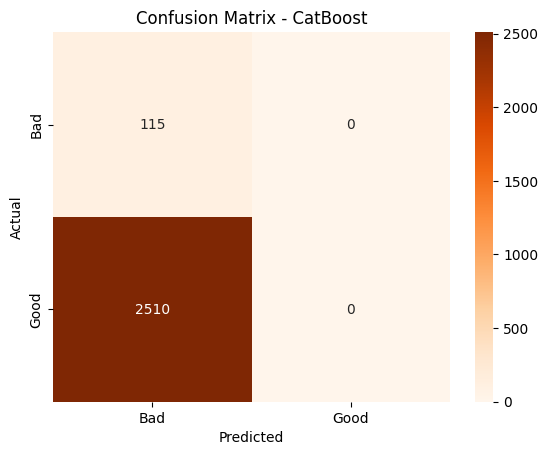


=== LightGBM ===
              precision    recall  f1-score   support

         Bad       0.96      0.61      0.74       115
        Good       0.98      1.00      0.99      2510

    accuracy                           0.98      2625
   macro avg       0.97      0.80      0.87      2625
weighted avg       0.98      0.98      0.98      2625



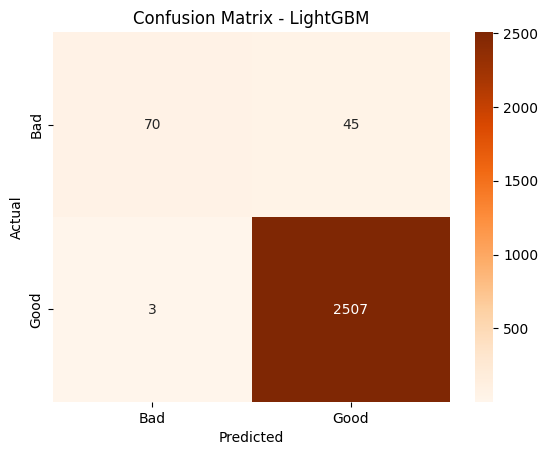


=== XGBoost ===
              precision    recall  f1-score   support

         Bad       0.97      0.63      0.77       115
        Good       0.98      1.00      0.99      2510

    accuracy                           0.98      2625
   macro avg       0.98      0.82      0.88      2625
weighted avg       0.98      0.98      0.98      2625



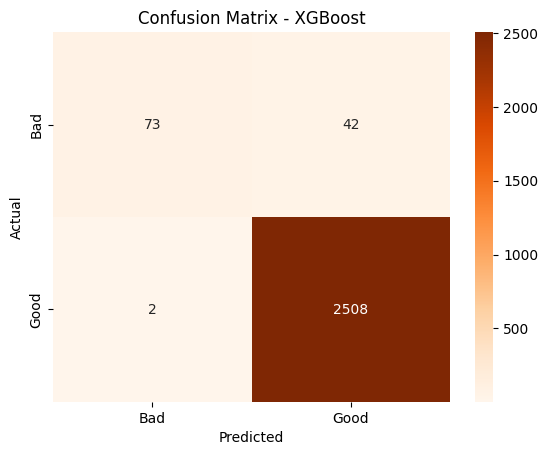


=== LSTM ===
              precision    recall  f1-score   support

         Bad       0.87      0.50      0.64       115
        Good       0.98      1.00      0.99      2510

    accuracy                           0.97      2625
   macro avg       0.92      0.75      0.81      2625
weighted avg       0.97      0.97      0.97      2625



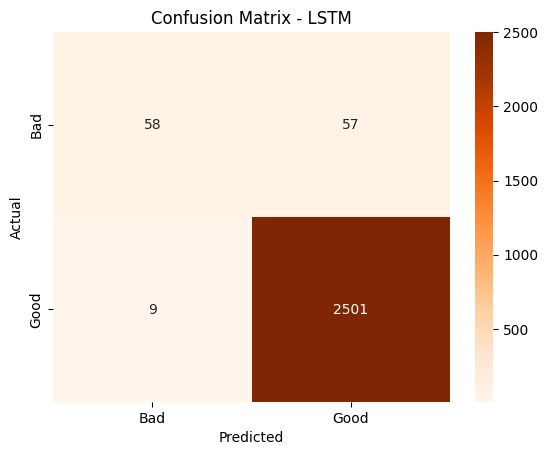

In [ ]:
evaluate_model(y_val, cat_model.predict(X_val), labels, "CatBoost")
evaluate_model(y_val, lgb_model.predict(X_val), labels, "LightGBM")
evaluate_model(y_val, xgb_model.predict(X_val), labels, "XGBoost")

lstm_model.eval()
with torch.no_grad():
    tensor_val = torch.tensor(X_val_scaled, dtype=torch.float32)
    preds_lstm = lstm_model(tensor_val)
    lstm_preds = torch.argmax(preds_lstm, dim=1).numpy()
evaluate_model(y_val, lstm_preds, labels, "LSTM")

## **Download LightGBM Model dalam format .pkl**

---



Alasan memilih LightGBM karena untuk masalah ini, metrik terpenting adalah F1-Score pada kelas 'Bad', karena ini mengukur keseimbangan antara precision (seberapa akurat prediksi 'Bad' Anda) dan recall (seberapa banyak kasus 'Bad' yang berhasil Anda temukan) pada kelas minoritas yang paling krusial.

In [ ]:
best_model = lgb_model
model_filename = 'Task2_model_operator_bad.pkl'
joblib.dump(best_model, model_filename)

['Task2_model_operator_bad.pkl']